# PRESEIS: Magnitude of completeness
This is a notebook which shows the different steps that go into making an Magnitude of completeness (MOC) estimate for a model space from a seismic network.

What is MOC?

The magnitude of completeness is the minimum magnitude earthquake which can be detected by a seismic network at a location.

Calculating an MOC requires a number of choices to be made;
- How high should the Signal to Noise ratio (`SNR`) be for a EQ to have been detected at a station?
- How many stations in a network are needed to say that an EQ has been 'detected'? (`NStations_threshold`) To locate its epicentre it is 2, and hypocentre it is only 3, but in reality often requires more. 
- What threshold of probability do we say is required to be sure of a detection? 99%? 95%? (`magnitude_of_completeness_percentile`)

This module calculates MOC in the following way; for a given EQ location (x,y,z) and a number of stations (x,y) the distance between the EQ and the stations are calculated.
From the epicentral distance the expected peak ground motion (PGM, [mm/s]) is calculated using a model published by: Ruigrok, Kruiver, Dost (2023), 
(KNMI report Section 2.2.2, found in this git repo under /resources/KNMIReport.pdf)

Then for each station this PGM is compared to the background noise expected at the station (an estimate provided by the user) and from this a probability of exceedance is calculated;
The probability that the PGM from the EQ is greater than the signal to noise ratio (SNR) specified by the user.

From this, the combined probability is calculated; that is the probability that for a given EQ `NStations_threshold` or more have a `pgm` > `SNR`.
This is then repeated for a range of magnitudes, and then the minimum magnitude where the combined probability is equal to `magnitude_of_completeness_percentile` is taken as the MOC.

This whole process is then also repeated in a 3D grid, where an EQ is assumed to occur at each point in the grid. This results in a 3D model of MOC.

In [1]:
import yaml
from modules.magnitude_of_completeness import *
from modules.magnitude_of_completeness.plotting import plot_grid_cross_sections

In [2]:
# read the example config
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

# initiate the station and grid objects for
stations, grid = initiate_stations_and_grid_from_config(config)

# define model parameters for magnitude of completeness calculation
mags = np.arange(-2, 5.0, 0.25)
magnitudes = xr.DataArray(mags, coords={"magnitude": mags})
SNR = 2.0
NStation_threshold = 4
magnitude_of_completeness_percentile = 0.95

In [3]:
# calculate epicentral distance for each station
grid_ep_dist = epicentral_distance_calc_grid(
    grid["x"], grid["y"], stations["x"], stations["y"]
)

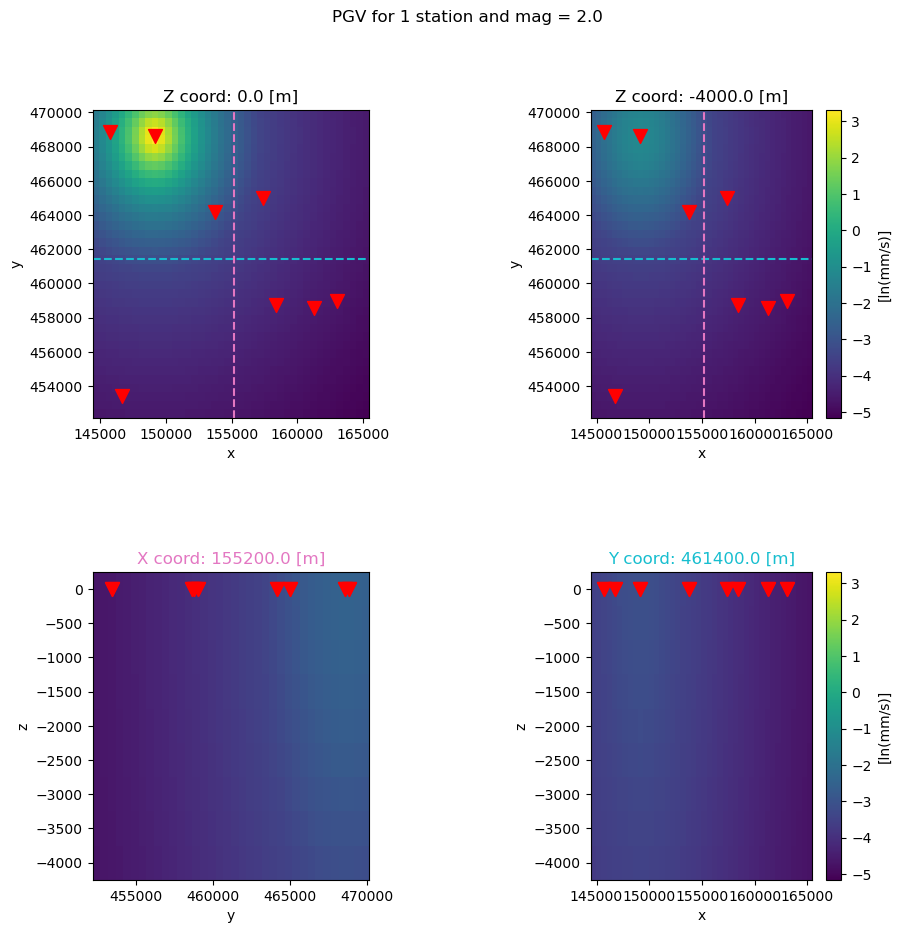

In [4]:
# calculate peak ground motion for all magnitudes for all stations
pgm = xr.apply_ufunc(
    ground_motion_model,
    magnitudes,
    grid["z"] * 0.001,
    stations["z"] * 0.001,
    grid_ep_dist * 0.001,
    kwargs={"model_params": config["input"]["GMPE"]},
)
pgm_SD = config["input"]["GMPE"]["pgm_sd"]
plot_grid_cross_sections(
    pgm.sel(station="0", magnitude=2.0),
    "PGV for 1 station and mag = 2.0",
    "[ln(mm/s)]",
    stationlocs=stations,
)

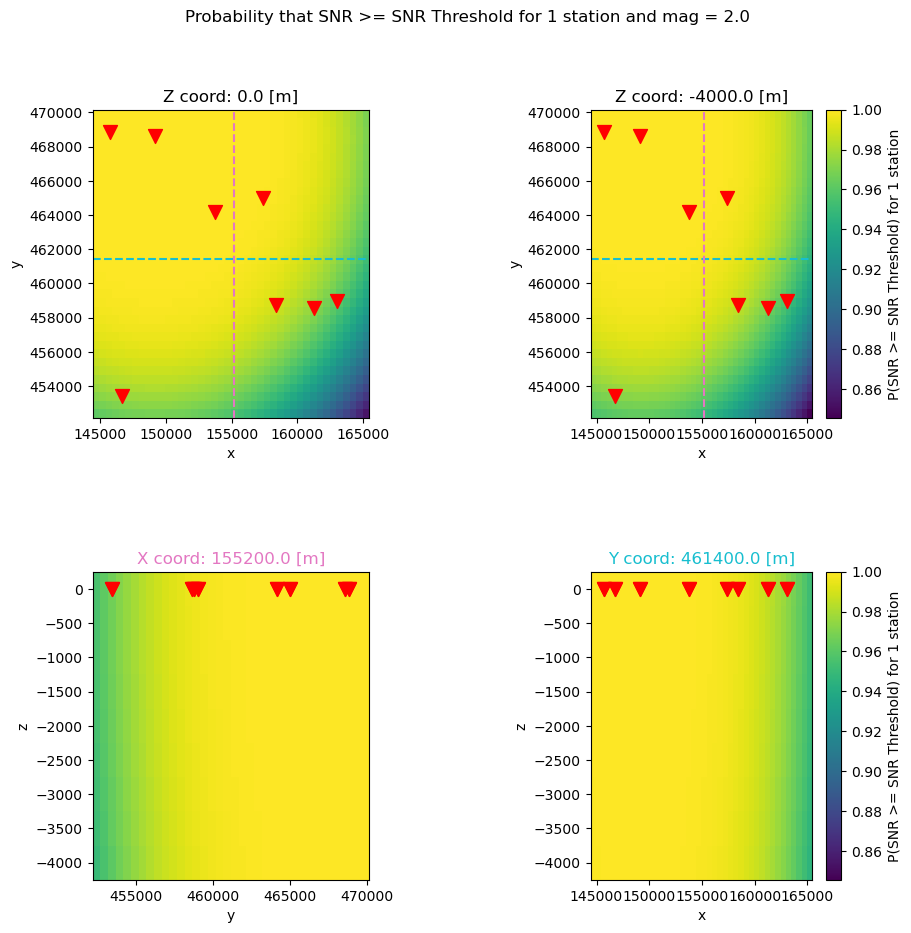

In [5]:
# calculate the probabilities that SNR > threshold for each station and magnitude
SNR_probability = xr.apply_ufunc(
    probability_of_exceedance,
    pgm,
    pgm_SD,
    stations["noise_mean"],
    stations["noise_SD"],
    SNR,
)
plot_grid_cross_sections(
    SNR_probability.sel(station="0", magnitude=2.0),
    "Probability that SNR >= SNR Threshold for 1 station and mag = 2.0",
    "P(SNR >= SNR Threshold) for 1 station",
    stationlocs=stations,
)

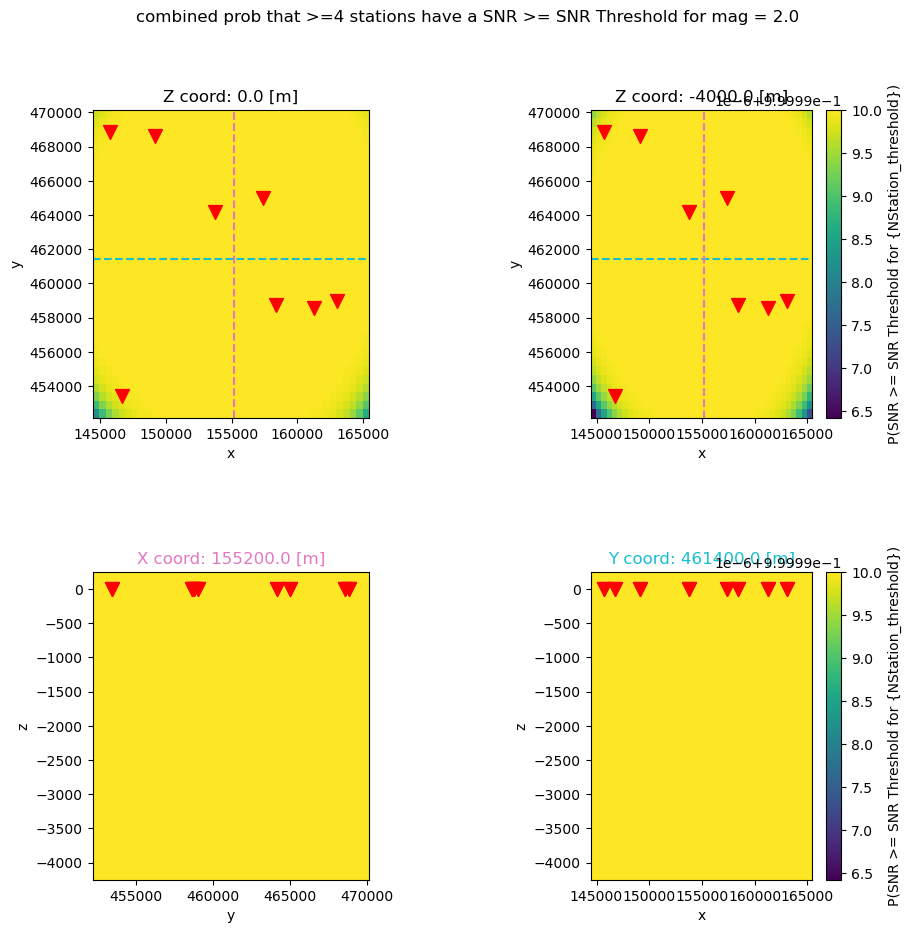

In [6]:
# calculate combined probability grids:
combined_probability_grid = xr.apply_ufunc(
    calculate_probability_of_NThreshold_occurances,
    SNR_probability,
    NStation_threshold,
    input_core_dims=[["station"], []],
    exclude_dims={"station"},
    vectorize=True,
)
plot_grid_cross_sections(
    combined_probability_grid.sel(magnitude=2.0),
    f"combined prob that >={NStation_threshold} stations have a SNR >= SNR Threshold for mag = 2.0",
    "P(SNR >= SNR Threshold for {NStation_threshold})",
    stationlocs=stations,
)

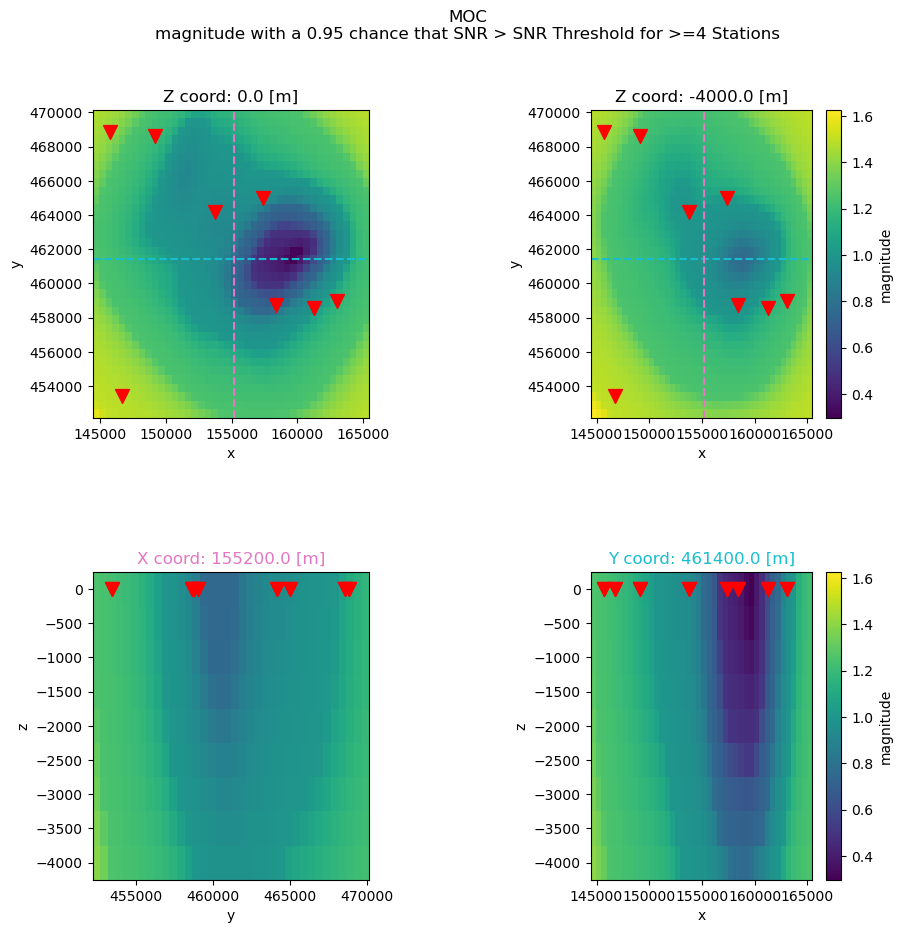

In [7]:
# calculate magnitude of completeness
magnitude_of_completeness = xr.apply_ufunc(
    interpolate_magnitude_of_completeness,
    combined_probability_grid,
    combined_probability_grid.magnitude,
    magnitude_of_completeness_percentile,
    input_core_dims=[["magnitude"], ["magnitude"], []],
    vectorize=True,
)
plot_grid_cross_sections(
    magnitude_of_completeness,
    f"MOC\nmagnitude with a 0.95 chance that SNR > SNR Threshold for >={NStation_threshold} Stations",
    "magnitude",
    stationlocs=stations,
)